# Notebook containing the figures

In [50]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)
n_iterations = 10

## Functions used for positive and negative updates

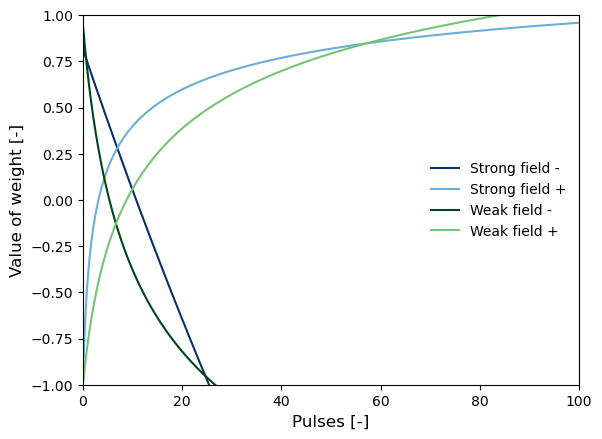

In [51]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## Load dataframe from simulation

In [52]:
# Create a pandas dataframe with columns type, mean, std, learning rate
df = pd.DataFrame(columns=["task", "type_devices", "n_devices", "accuracies", "learning_rate", "weights_path", "mean", "std", "scale", "noise", "mean_abs_grad"])
# get all paths
paths = [f for f in os.listdir(SIMULATION_FOLDER) if os.path.isdir(os.path.join(SIMULATION_FOLDER, f)) and ("simple" in f or "double" in f)]

for path in paths:
    try:
        # first dim of the tensor is the iteration
        accuracies = []
        mean_abs_grad = []
        weights = ""
        for it in range(n_iterations):
            current_folder = os.path.join(SIMULATION_FOLDER, path)
            accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
            mean_abs_grad.append(torch.load(os.path.join(current_folder, path+f"-{it}-gradients.pth")))
            if it == 0:
                weights = path+f"-{it}-weights.pth"     
        accuracies = torch.stack(accuracies)    
        mean = accuracies.mean(dim=0)[-1].item()*100
        std = accuracies.std(dim=0)[-1].item()*100
        mean_abs_grad = torch.stack(mean_abs_grad).mean(dim=0)[0].item()
        task = path.split("-")[1]
        n_devices = path.split("-")[2]
        type_devices = path.split("-")[3]
        learning_rate = float(path.split("-")[4])
        scale = float(path.split("-")[8])
        noise = float(path.split("-")[10])
        df = df.append({"task": task, 
                        "type_devices": type_devices, 
                        "n_devices": n_devices, 
                        "accuracies": accuracies, 
                        "learning_rate": learning_rate, 
                        "weights_path": weights, 
                        "mean": mean, 
                        "std": std,
                        "mean_abs_grad": mean_abs_grad,
                        "noise": noise,
                        "scale": scale}, ignore_index=True)
    except Exception as e:
        pass
df

,task,type_devices,n_devices,accuracies,learning_rate,weights_path,mean,std,scale,noise,mean_abs_grad
0,MNIST,exponential,double,"[[tensor(0.9594), tensor(0.9682), tensor(0.971...",0.5,20240722165733-MNIST-double-exponential-0.5-sw...,97.801000,0.054457,1.0,0.000,0.000288
1,Fashion,exponential,double,"[[tensor(0.8334), tensor(0.8430), tensor(0.852...",0.5,20240722165743-Fashion-double-exponential-0.5-...,86.853999,0.229648,1.0,0.000,0.000401
2,MNIST,exponential,double,"[[tensor(0.9525), tensor(0.9645), tensor(0.968...",1.0,20240722170245-MNIST-double-exponential-1.0-sw...,97.496003,0.058157,1.0,0.000,0.000355
3,Fashion,exponential,double,"[[tensor(0.8340), tensor(0.8462), tensor(0.850...",1.0,20240722170310-Fashion-double-exponential-1.0-...,86.142999,0.124993,1.0,0.000,0.000514
4,MNIST,exponential,double,"[[tensor(0.9254), tensor(0.9453), tensor(0.953...",5.0,20240722170805-MNIST-double-exponential-5.0-sw...,96.504003,0.145923,1.0,0.000,0.000515
...,...,...,...,...,...,...,...,...,...,...,...
123,MNIST,linear,double,"[[tensor(0.9260), tensor(0.9370), tensor(0.945...",30.0,20240723090508-MNIST-double-linear-30.0-switch...,96.020001,0.094751,1.0,0.005,0.119914
124,MNIST,linear,double,"[[tensor(0.8373), tensor(0.8752), tensor(0.890...",200.0,20240723090740-MNIST-double-linear-200.0-switc...,92.095006,0.354001,1.0,0.005,0.797852
125,MNIST,exponential,double,"[[tensor(0.7872), tensor(0.8007), tensor(0.799...",200.0,20240723091012-MNIST-double-exponential-200.0-...,78.575003,0.743389,1.0,0.005,0.812015
126,MNIST,exponential,double,"[[tensor(0.8742), tensor(0.8844), tensor(0.886...",200.0,20240723091748-MNIST-double-exponential-200.0-...,88.527000,0.241203,1.0,0.001,0.173561


## Accuracy vs learning rate

Plotting task MNIST with noise 0.0


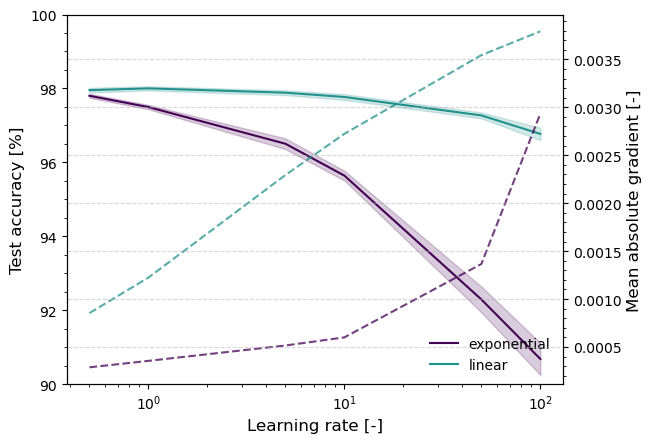

Plotting task MNIST with noise 0.001


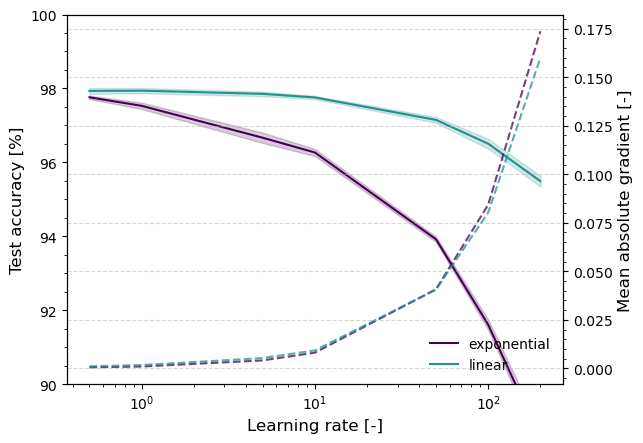

Plotting task MNIST with noise 0.005


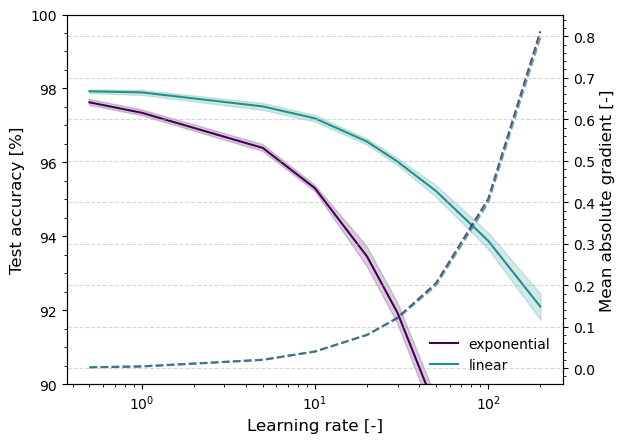

Plotting task MNIST with noise 0.01


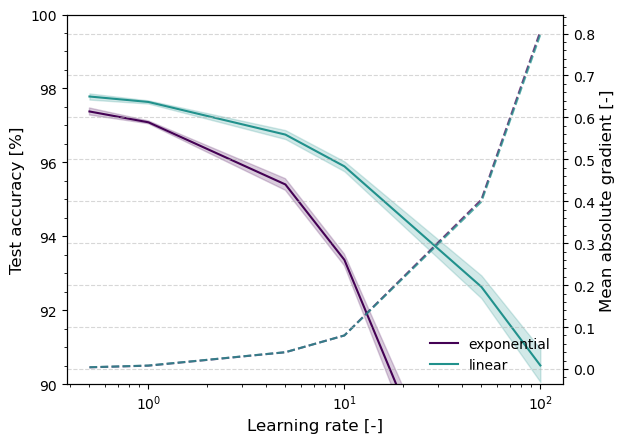

Plotting task MNIST with noise 0.05


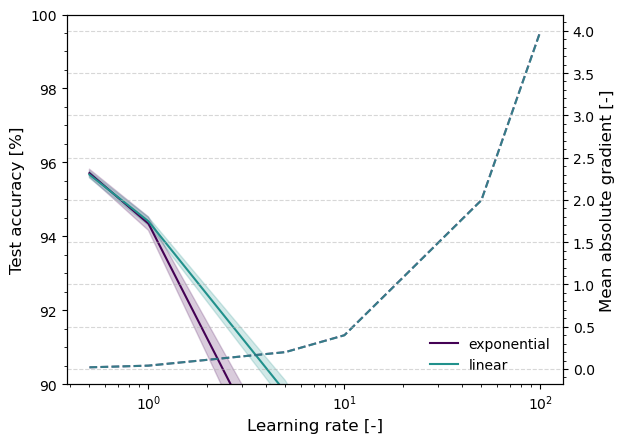

Plotting task Fashion with noise 0.0


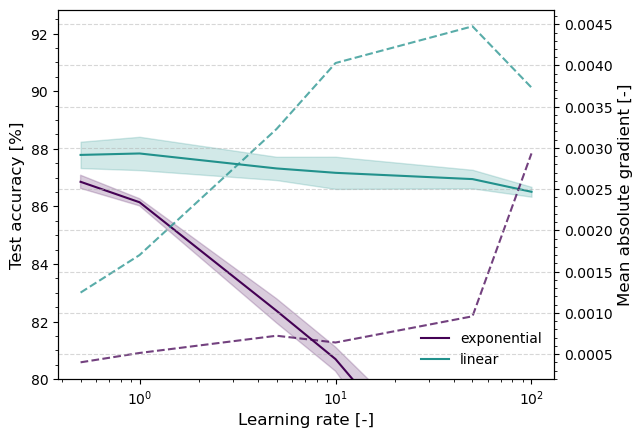

Plotting task Fashion with noise 0.001


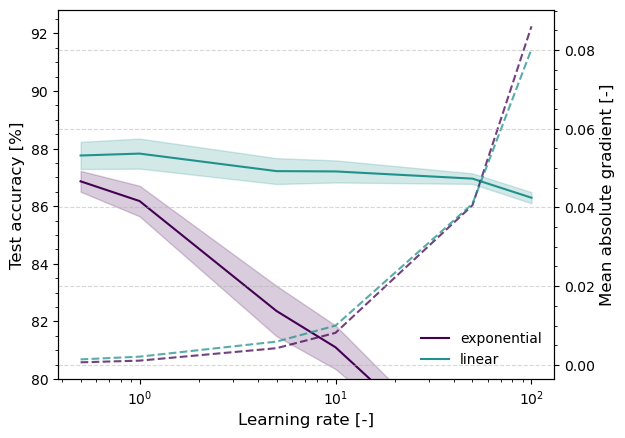

Plotting task Fashion with noise 0.005


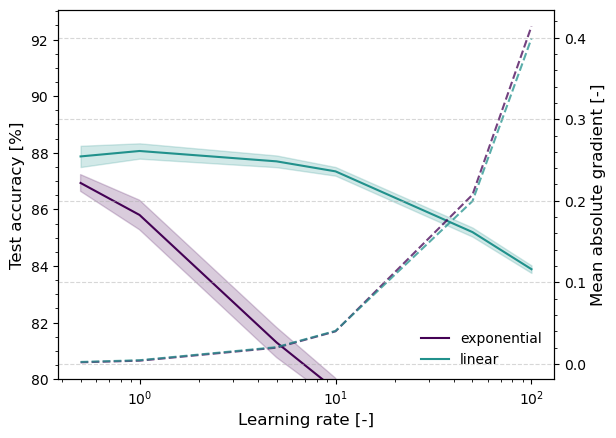

Plotting task Fashion with noise 0.01


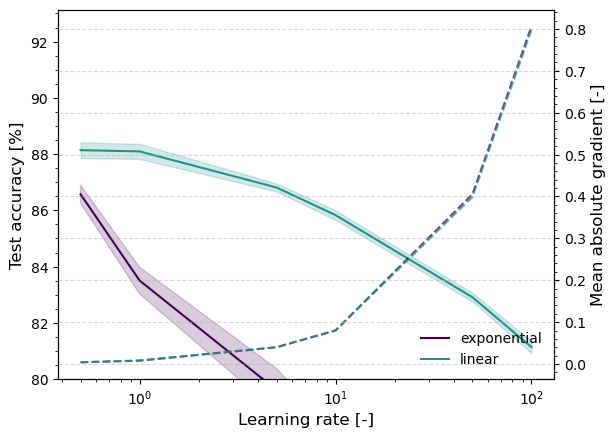

Plotting task Fashion with noise 0.05


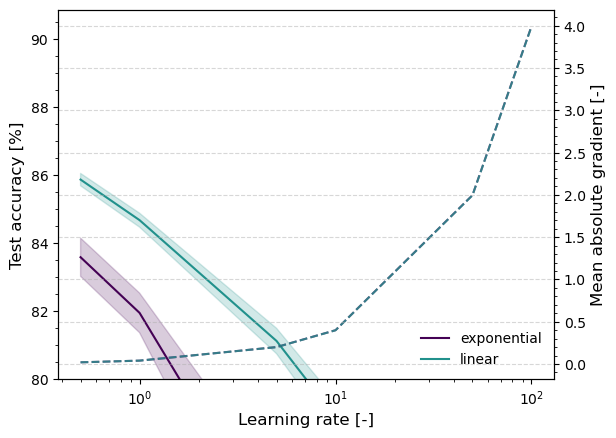

In [67]:
# for each task, plot the evolution of the accuracy
for task in df["task"].unique():
    for noise in df["noise"].unique():
        print(f"Plotting task {task} with noise {noise}")
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
        palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
        df_filtered = df[(df["task"] == task) & (df["noise"] == noise)].sort_values("learning_rate")
        for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):
            ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i))
            ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
            ax2.plot(group["learning_rate"], group["mean_abs_grad"], linestyle='--', color=palette(i), alpha=0.75, zorder=-1)
        # for lr in df_filtered["learning_rate"].unique():
        #     ax.axvline(lr, color='black', linestyle='--', alpha=0.1, zorder=-1)
        # h grid every 0.05
        ax2.grid(axis='y', which='major', linestyle='--', alpha=0.5)
        ax.set_xscale('log')
        ax2.set_xscale('log')
        ax2.set_ylabel("Mean absolute gradient [-]", fontsize=12)
        ax.set_xlabel("Learning rate [-]", fontsize=12)
        ax.set_ylabel("Test accuracy [%]", fontsize=12)
        ax.legend(loc='lower right', fontsize=10, frameon=False)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        offset = 5
        minimum = 95 if task == "MNIST" else 80
        maximum = min(100, df_filtered["mean"].max() + offset)
        ax.set_ylim([minimum, maximum])
        ax.set_ylim([minimum, maximum])
        plt.show()
        # save as pdf and svg
        name = f"learning-rate-{task}-noise-{noise}-{GRAPHS_ID}"
        fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')